In [64]:
#import all required libraries for data analysis

import config

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix,confusion_matrix,classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score,accuracy_score,jaccard_score,f1_score,log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# data scaling
from sklearn.preprocessing import StandardScaler


# dependencies for Data Augmentation
import copy
from collections import Counter
from numpy import where
from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline

# dependencies to read data from pgadmin
from sqlalchemy import create_engine
from sqlalchemy import inspect
import psycopg2 as pg
import pandas.io.sql as psql

# 1. Exploring Data

In [65]:
# Conncet to postgresql dataBase table
protocol = 'postgresql'
username = 'postgres'
password = config.password
host = 'localhost'
port = 5432
database_name = 'Project4_db'

pg_connection = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'


In [66]:

#Create DataFrame from SQL table 
pg_connection = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
conn = pg.connect(pg_connection)
raw_ibm_df = psql.read_sql('SELECT * FROM ibm_employee_data', conn)

# Display all the DataFrame Columns 
pd.options.display.max_columns = None
display(raw_ibm_df)


,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


In [10]:
raw_ibm_df.columns


Index(['age', 'attrition', 'businesstravel', 'dailyrate', 'department',
       'distancefromhome', 'education', 'educationfield', 'employeecount',
       'employeenumber', 'environmentsatisfaction', 'gender', 'hourlyrate',
       'jobinvolvement', 'joblevel', 'jobrole', 'jobsatisfaction',
       'maritalstatus', 'monthlyincome', 'monthlyrate', 'numcompaniesworked',
       'over18', 'overtime', 'percentsalaryhike', 'performancerating',
       'relationshipsatisfaction', 'standardhours', 'stockoptionlevel',
       'totalworkingyears', 'trainingtimeslastyear', 'worklifebalance',
       'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion',
       'yearswithcurrmanager'],
      dtype='object')

In [11]:
df = raw_ibm_df.rename(columns = {'age' : 'Age', 
                                        'attrition' :'Attrition', 
                                        'businesstravel' : 'BusinessTravel', 
                                        'dailyrate' : 'DailyRate', 
                                        'department' : 'Department',
                                        'distancefromhome' : 'DistanceFromHome', 
                                        'education' : 'Education', 
                                        'educationfield' : 'EducationField', 
                                        'employeecount' : 'EmployeeCount',
                                        'employeenumber' : 'EmployeeNumber', 
                                        'environmentsatisfaction' : 'EnvironmentSatisfaction', 
                                        'gender' : 'Gender', 
                                        'hourlyrate' : 'HourlyRate',
                                        'jobinvolvement' : 'JobInvolvement', 
                                        'joblevel' : 'JobLevel', 
                                        'jobrole' : 'JobRole', 
                                        'jobsatisfaction' : 'JobSatisfaction',
                                        'maritalstatus' : 'MaritalStatus', 
                                        'monthlyincome' : 'MonthlyIncome', 
                                        'monthlyrate' : 'MonthlyRate', 
                                        'numcompaniesworked' : 'NumCompaniesWorked',
                                        'over18' : 'Over18', 
                                        'overtime' : 'OverTime', 
                                        'percentsalaryhike' : 'PercentSalaryHike', 
                                        'performancerating' : 'PerformanceRating',
                                        'relationshipsatisfaction' : 'RelationshipSatisfaction', 
                                        'standardhours' : 'StandardHours', 
                                        'stockoptionlevel' : 'StockOptionLevel',
                                        'totalworkingyears' : 'TotalWorkingYears', 
                                        'trainingtimeslastyear' : 'TrainingTimesLastYear', 
                                        'worklifebalance' : 'WorkLifeBalance',
                                        'yearsatcompany' : 'YearsAtCompany', 
                                        'yearsincurrentrole': 'YearsInCurrentRole', 
                                        'yearssincelastpromotion' : 'YearsSinceLastPromotion',
                                        'yearswithcurrmanager' : 'YearsWithCurrManager'
})
display(df.head())

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [12]:
# check datatype and other information for each feature
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.0,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.0,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.0,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.0,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.0,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.0,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.0,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.0,2.0,3.00,5.0
JobSatisfaction,1470.0,2.728571,1.102846,1.0,2.0,3.0,4.00,4.0


In [13]:
# the shape of the dataset
df.shape

(1470, 35)

In [14]:
# check missing data for each feature
df[df.isnull().any(axis=1)]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


In [15]:
# count unique values of each features
df.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBa

In [16]:
df = df.drop(['Over18','EmployeeNumber', 'EmployeeCount', 'StandardHours'], axis = 1)
print(df.shape)
df.head()

(1470, 31)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


In [17]:
# separate features into numerical and non numerical groups
df.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
        'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
        'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
        'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
        'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
        'YearsSinceLastPromotion', 'YearsWithCurrManager'],
       dtype='object'),
 dtype('O'): Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
        'JobRole', 'MaritalStatus', 'OverTime'],
       dtype='object')}

In [18]:
# Seperating the numerical and categorical columns
categorical = df.select_dtypes(include = 'object')
print(categorical.columns)


Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'OverTime'],
      dtype='object')


In [19]:
numerical = df.select_dtypes(include=['float64','int64'])
print((numerical.columns))

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


# 2. Distribution of the dataset

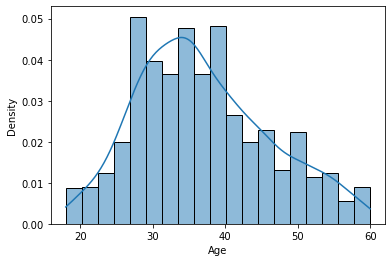

In [20]:
sns.histplot(df['Age'], kde=True, stat="density")
plt.savefig('outputs/Age_distribution.png')

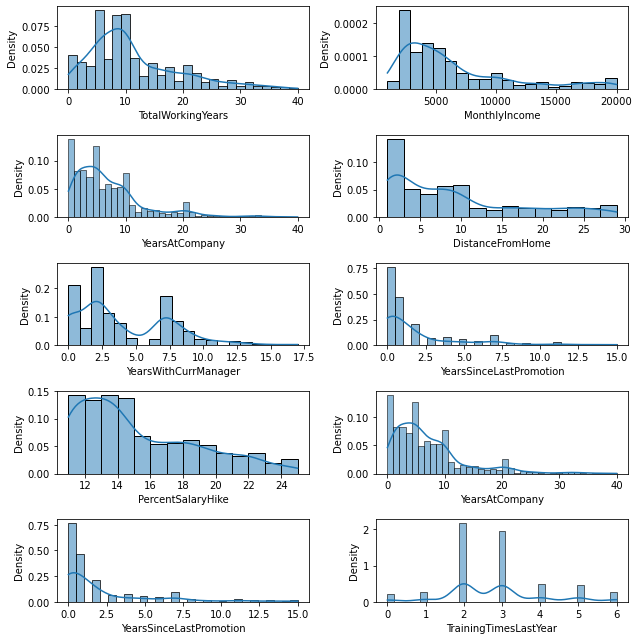

In [21]:
fig, ax = plt.subplots(5,2, figsize=(9,9))
sns.histplot(df['TotalWorkingYears'], kde=True, stat="density", ax = ax[0,0])
sns.histplot(df['MonthlyIncome'], kde=True, stat="density", ax = ax[0,1])
sns.histplot(df['YearsAtCompany'], kde=True, stat="density", ax = ax[1,0])
sns.histplot(df['DistanceFromHome'], kde=True, stat="density", ax = ax[1,1])
sns.histplot(df['YearsWithCurrManager'], kde=True, stat="density", ax = ax[2,0])
sns.histplot(df['YearsSinceLastPromotion'], kde=True, stat="density", ax = ax[2,1])
sns.histplot(df['PercentSalaryHike'], kde=True, stat="density", ax = ax[3,0])
sns.histplot(df['YearsAtCompany'], kde=True, stat="density", ax = ax[3,1])
sns.histplot(df['YearsSinceLastPromotion'], kde=True, stat="density", ax = ax[4,0])
sns.histplot(df['TrainingTimesLastYear'], kde=True, stat="density", ax = ax[4,1])
plt.tight_layout()
plt.savefig('outputs/dataset_distribution.png')
plt.show()

# 3. Feature engineering

In [22]:
# tranform binary feature into 0 and 1
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

In [23]:
# check correlation between numerical features and target variable
corr_score = df[['Age', 'DailyRate', 'DistanceFromHome', 'Education',
        'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
        'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
        'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
        'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
        'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition']].corr()
corr_score

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
Age,1.000000,0.010661,-0.001686,0.208034,0.010146,0.024287,0.029820,0.509604,-0.004892,0.497855,0.028051,0.299635,0.003634,0.001904,0.053535,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089,-0.159205
DailyRate,0.010661,1.000000,-0.004985,-0.016806,0.018355,0.023381,0.046135,0.002966,0.030571,0.007707,-0.032182,0.038153,0.022704,0.000473,0.007846,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363,-0.056652
DistanceFromHome,-0.001686,-0.004985,1.000000,0.021042,-0.016075,0.031131,0.008783,0.005303,-0.003669,-0.017014,0.027473,-0.029251,0.040235,0.027110,0.006557,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406,0.077924
Education,0.208034,-0.016806,0.021042,1.000000,-0.027128,0.016775,0.042438,0.101589,-0.011296,0.094961,-0.026084,0.126317,-0.011111,-0.024539,-0.009118,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065,-0.031373
EnvironmentSatisfaction,0.010146,0.018355,-0.016075,-0.027128,1.000000,-0.049857,-0.008278,0.001212,-0.006784,-0.006259,0.037600,0.012594,-0.031701,-0.029548,0.007665,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999,-0.103369
HourlyRate,0.024287,0.023381,0.031131,0.016775,-0.049857,1.000000,0.042861,-0.027853,-0.071335,-0.015794,-0.015297,0.022157,-0.009062,-0.002172,0.001330,0.050263,-0.002334,-0.008548,-0.004607,-0.019582,-0.024106,-0.026716,-0.020123,-0.006846
JobInvolvement,0.029820,0.046135,0.008783,0.042438,-0.008278,0.042861,1.000000,-0.012630,-0.021476,-0.015271,-0.016322,0.015012,-0.017205,-0.029071,0.034297,0.021523,-0.005533,-0.015338,-0.014617,-0.021355,0.008717,-0.024184,0.025976,-0.130016
JobLevel,0.509604,0.002966,0.005303,0.101589,0.001212,-0.027853,-0.012630,1.000000,-0.001944,0.950300,0.039563,0.142501,-0.034730,-0.021222,0.021642,0.013984,0.782208,-0.018191,0.037818,0.534739,0.389447,0.353885,0.375281,-0.169105
JobSatisfaction,-0.004892,0.030571,-0.003669,-0.011296,-0.006784,-0.071335,-0.021476,-0.001944,1.000000,-0.007157,0.000644,-0.055699,0.020002,0.002297,-0.012454,0.010690,-0.020185,-0.005779,-0.019459,-0.003803,-0.002305,-0.018214,-0.027656,-0.103481
MonthlyIncome,0.497855,0.007707,-0.017014,0.094961,-0.006259,-0.015794,-0.015271,0.950300,-0.007157,1.000000,0.034814,0.149515,-0.027269,-0.017120,0.025873,0.005408,0.772893,-0.021736,0.030683,0.514285,0.363818,0.344978,0.344079,-0.159840


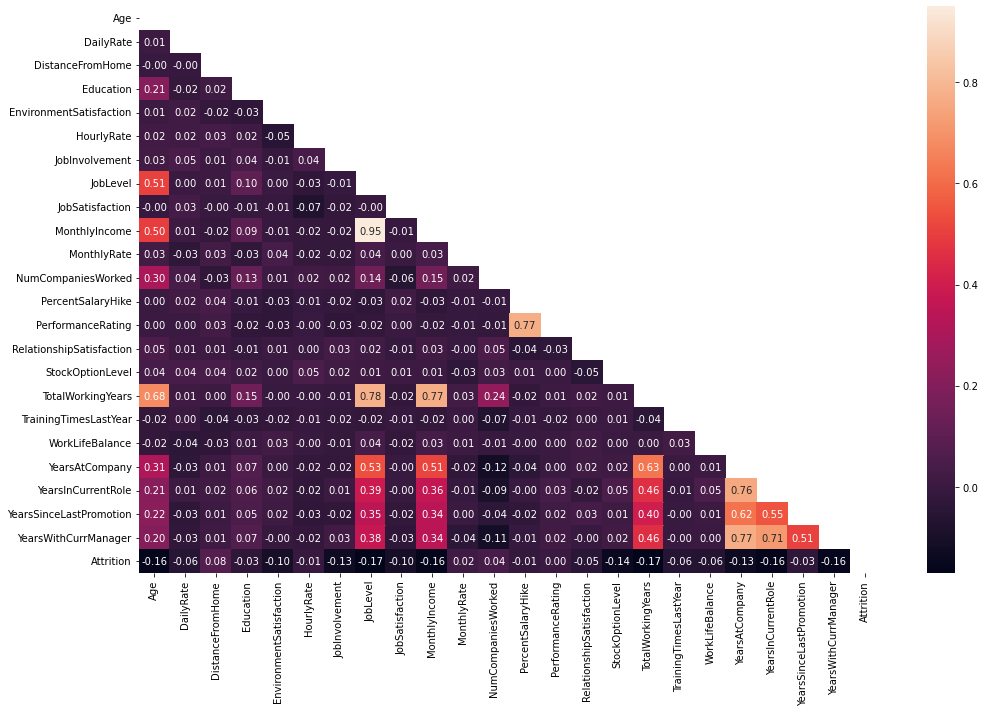

In [24]:
# visualization of correlation relationships
plt.figure(figsize=(15, 10))
mask = np.triu(corr_score)
sns.heatmap(corr_score,annot = True, fmt = '.2f',mask = mask)
plt.tight_layout()
plt.savefig('outputs/correlation_heatmap.png')

In [25]:
# Drop the target column and get a clean dataframe with features
y = df['Attrition']
df_clean = df.drop(columns = ['Attrition'])

In [26]:
# apply one hot encoding to non numerical features
df_clean = pd.get_dummies(df_clean, columns = ['BusinessTravel', 'Gender','MaritalStatus'], drop_first = True)
df_clean = pd.get_dummies(df_clean)
df_clean.head()


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,49,279,8,1,3,61,2,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,27,591,2,1,1,40,3,1,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [27]:
# check the columns we have after feature engineering
print(list(df_clean.columns))

['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Gender_Male', 'MaritalStatus_Married', 'MaritalStatus_Single', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Directo

In [28]:
# check the shape for the new dataset
df_clean.shape


(1470, 47)

# 4. Data Scaling

In [29]:
# filter out features that needs to be standarized
col_tobe_standard = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 
                   'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 
                   'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 
                   'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 
                   'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 
                   'YearsWithCurrManager']

In [30]:
# standarization on numercial features so that all the numerical features are having the same type of normal distribution
scaler = StandardScaler()
for col in col_tobe_standard:
    df_clean[col] = df_clean[col].astype(float)
    df_clean[[col]] = scaler.fit_transform(df_clean[[col]])
df_clean.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,0.446350,0.742527,-1.010909,-0.891688,-0.660531,1.383138,0.379672,-0.057788,1.153254,-0.108350,0.726020,2.125136,1,-1.150554,-0.426230,-1.584178,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1.322365,-1.297775,-0.147150,-1.868426,0.254625,-0.240677,-1.026167,-0.057788,-0.660853,-0.291719,1.488876,-0.678049,0,2.129306,2.346151,1.191438,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715,0.806541,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.008343,1.414363,-0.887515,-0.891688,1.169781,1.284725,-1.026167,-0.961486,0.246200,-0.937654,-1.674841,1.324226,1,-0.057267,-0.426230,-0.658973,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,-0.429664,1.461466,-0.764121,1.061787,1.169781,-0.486709,0.379672,-0.961486,0.246200,-0.763634,1.243211,-0.678049,1,-1.150554,-0.426230,0.266233,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146,-1.155935,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,-1.086676,-0.524295,-0.887515,-1.868426,-1.575686,-1.274014,0.379672,-0.961486,-0.660853,-0.644858,0.325900,2.525591,0,-0.877232,-0.426230,1.191438,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-0.595227,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


# 5. Model training and performance evaluation

In [31]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_clean,
                                                                    y,
                                                                    test_size=0.25,
                                                                    stratify = y)  
print('Training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('Test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')


Training data has 1102 observation with 47 features
Test data has 368 observation with 47 features


In [32]:
# build different machine learning models with the same random state if applicable
lr = LogisticRegression(random_state = 6, solver='liblinear', max_iter=1000)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state = 6)
dt = DecisionTreeClassifier(random_state = 6)
mlp = MLPClassifier(random_state = 6)
xg = xgb.XGBClassifier(random_state = 6)

In [33]:
# naive approach on each models without hyperparameter tuning
model_list = [lr,knn,rf,dt,mlp,xg]
score_res = []
for model in model_list:
    draft = model_selection.cross_val_score(model, X_train, y_train, cv = 5)
    score_res.append(draft)


c:\Users\dalem\anaconda3\envs\PythonData\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\dalem\anaconda3\envs\PythonData\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\dalem\anaconda3\envs\PythonData\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\dalem\anaconda3\envs\PythonData\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  Converge

In [34]:
# print out naive approach performance
model_names = ['Logistic Regression', 'KNN', 'Random Forest','Decision Tree','Neural Network','XG Boost']
idx = ['cv_1','cv_2','cv_3','cv_4','cv_5']
df_accuracy = pd.DataFrame(np.array(score_res).T, columns = model_names, index = idx).round(decimals=3)
print('='*60)
print('The Score is listed below \n\n',df_accuracy)
print('='*60)

The Score is listed below 

       Logistic Regression    KNN  Random Forest  Decision Tree  \
cv_1                0.878  0.842          0.846          0.774   
cv_2                0.860  0.833          0.855          0.801   
cv_3                0.873  0.832          0.841          0.791   
cv_4                0.882  0.850          0.859          0.755   
cv_5                0.886  0.845          0.850          0.764   

      Neural Network  XG Boost  
cv_1           0.842     0.837  
cv_2           0.860     0.878  
cv_3           0.845     0.836  
cv_4           0.836     0.850  
cv_5           0.873     0.841  


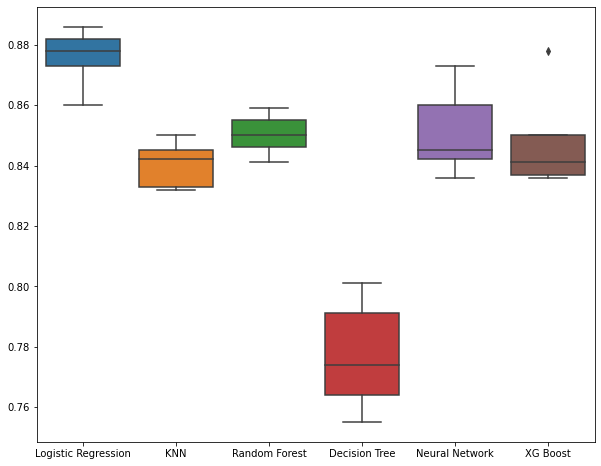

In [35]:
# visualize the performance of different machine learning models
plt.figure(figsize=(10, 8))
sns.boxplot(data = df_accuracy)
plt.savefig('outputs/ML_performance.png')

In [36]:
# helper function to get best parameters from best model after grid search cross validation
best_models = []
def get_grid_res(gs):
    print("Best Score:", "{:.3f}".format(gs.best_score_))
    print("Best Parameters:")
    best_params = gs.best_params_
    for k, v in best_params.items():
        print(k, ":", v)

In [37]:
# set kfold number for k fold cross validation method
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state = 6)

In [38]:
# hyperparameter tuning for logistic regression
lr_params = {'penalty':('l1', 'l2'), 
          'C':(0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10)}

In [39]:
# apply grid search on each hyperparameter and fit in with data
grid_lr = GridSearchCV(lr, lr_params, cv= kfold)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=6, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, random_state=6,
                                          solver='liblinear'),
             param_grid={'C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10),
                         'penalty': ('l1', 'l2')})

In [40]:
lr_res = grid_lr.cv_results_

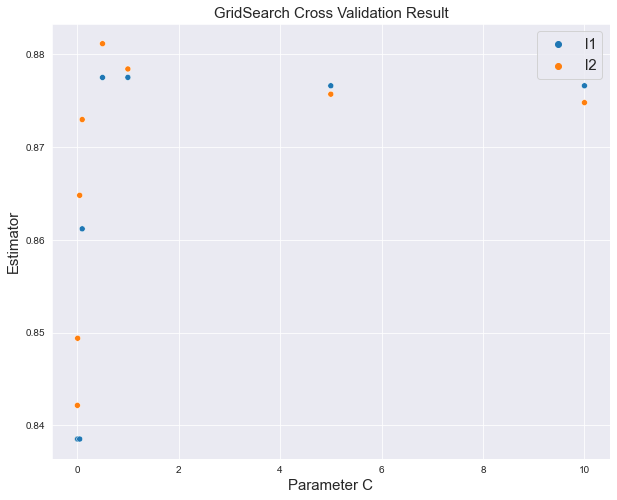

In [41]:
# visualize the affect of different hyperparameters on performance
sns.set_style('darkgrid')
plt.figure(figsize=(10, 8))
sns.scatterplot(x = 'param_C', y = 'mean_test_score',hue = 'param_penalty',data = lr_res)
plt.xlabel('Parameter C',fontsize = 15)
plt.ylabel('Estimator',fontsize = 15)
plt.title('GridSearch Cross Validation Result',fontsize = 15)
plt.legend(fontsize = 15)

In [42]:
# apply helper function to get the best hyperparameter
get_grid_res(grid_lr)

Best Score: 0.881
Best Parameters:
C : 0.5
penalty : l2


In [43]:
best_lr_model = grid_lr.best_estimator_

In [44]:
# append the best model to the list for other evalution
best_models.append(('Logistic Regression', best_lr_model))

In [45]:
# hyperparameter tuning for K nearest neighbors
knn_params = {
    'n_neighbors':[3,5,7,9,11,13,15,17,21,31,59,61,63] 
}

In [46]:
# apply grid search on each hyperparameter and fit in with data
grid_knn = GridSearchCV(knn, knn_params, cv= kfold)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=6, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 21, 31, 59,
                                         61, 63]})

In [47]:
knn_res = grid_knn.cv_results_

Text(0.5, 1.0, 'GridSearch Cross Validation Result')

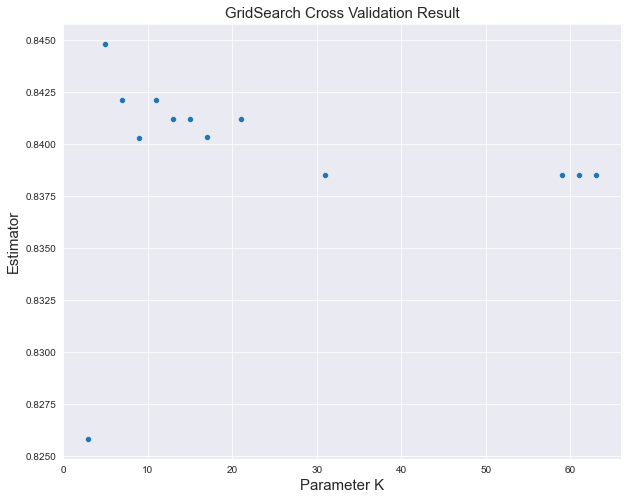

In [48]:
# visualize the affect of different hyperparameters on performance
sns.set_style('darkgrid')
plt.figure(figsize=(10, 8))
sns.scatterplot(x = 'param_n_neighbors', y = 'mean_test_score',data = knn_res)
plt.xlabel('Parameter K',fontsize = 15)
plt.ylabel('Estimator',fontsize = 15)
plt.title('GridSearch Cross Validation Result',fontsize = 15)

In [49]:
# apply helper function to get the best hyperparameter
get_grid_res(grid_knn)

best_knn_model = grid_knn.best_estimator_

# append the best model to the list for other evalution
best_models.append(('K Nearest Neighbors',best_knn_model))

Best Score: 0.845
Best Parameters:
n_neighbors : 5


In [50]:
# hyperparameter tuning for random forest
params_rf = {
    'n_estimators': [20,40,60,80],
    'min_samples_split':[4,6,8],
    'max_depth': [1, 5, 10, 15],
    'max_features': ['sqrt']
}
grid_rf = GridSearchCV(rf,params_rf, cv=kfold)
grid_rf.fit(X_train, y_train)

# apply helper function to get the best hyperparameter
get_grid_res(grid_rf)
rf_res = grid_rf.cv_results_
best_rf_model = grid_rf.best_estimator_

# append the best model to the list for other evalution
best_models.append(('Random Forest', best_rf_model))

Best Score: 0.852
Best Parameters:
max_depth : 15
max_features : sqrt
min_samples_split : 6
n_estimators : 20


In [51]:
# hyperparameter tuning for decision tree
params_dt = {
    'max_depth':[1,5,10,15],
    'min_samples_split':[2,4,6,8,10]
}
grid_dt = GridSearchCV(dt,params_dt, cv=kfold)
grid_dt.fit(X_train, y_train)

# apply helper function to get the best hyperparameter
get_grid_res(grid_dt)

best_dt_model = grid_dt.best_estimator_

# append the best model to the list for other evalution
best_models.append(('Decision Tree', best_dt_model))

Best Score: 0.839
Best Parameters:
max_depth : 1
min_samples_split : 2


In [52]:
# hyperparameter tuning for multi layer perceptrons
params_mlp = {
    'hidden_layer_sizes': [(10,),(20,),(30,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.001, 0.01, 0.1]
}
grid_mlp = GridSearchCV(mlp,params_mlp, cv = kfold, verbose=0,n_jobs= -1)
grid_mlp.fit(X_train, y_train)

# apply helper function to get the best hyperparameter
get_grid_res(grid_mlp)

best_mlp_model = grid_mlp.best_estimator_

# append the best model to the list for other evalution
best_models.append(('Neural Network', best_mlp_model))

Best Score: 0.877
Best Parameters:
activation : tanh
alpha : 0.1
hidden_layer_sizes : (20,)


c:\Users\dalem\anaconda3\envs\PythonData\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [53]:
# hyperparameter tuning for extreme boosting tree aka xgboost
params_xgb = {
        'subsample': [0.4, 0.6, 0.8],
        'max_depth': [1,5,10,15],
        'n_estimators':[40,60,80],
        'reg_alpha':[0.01, 0.05, 0.1, 0.5, 1, 5],
        'reg_lambda':[0.01, 0.05, 0.1, 0.5, 1, 5],
        'eta':[0.4,0.6,0.8],
        'learning_rate':[0.1, 0.3, 0.5]
        }

from sklearn.model_selection import RandomizedSearchCV
grid_xgb = RandomizedSearchCV(xg, params_xgb,cv = kfold,n_iter = 50)
grid_xgb.fit(X_train, y_train)

# apply helper function to get the best hyperparameter
get_grid_res(grid_xgb)

best_xgb_model = grid_xgb.best_estimator_

# append the best model to the list for other evalution
best_models.append(('Extreme Boosting Tree', best_xgb_model))

Best Score: 0.876
Best Parameters:
subsample : 0.4
reg_lambda : 0.01
reg_alpha : 1
n_estimators : 80
max_depth : 1
learning_rate : 0.3
eta : 0.6


In [54]:
# print out the list of optimized models
for name,model in best_models:
    print(name)

Logistic Regression
K Nearest Neighbors
Random Forest
Decision Tree
Neural Network
Extreme Boosting Tree


In [55]:
# helper function to print out and visualize the evaluation result of each model including
# confusion matrix, precison-recall and f1 score
def plot_cm(models):
    sns.set_style('white')
    class_names = ['No','Yes']
    for model_name, model in models:
        cm = confusion_matrix(y_test,model.predict(X_test))
        tn = cm[0][0]
        fp = cm[0][1]
        fn = cm[1][0]
        tp = cm[1][1]
        accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
        precision = tp / (tp + fp + 0.0)
        recall = tp / (tp + fn + 0.0)
        f1 = 2 / (( 1 / precision) + ( 1 / recall))
        plot_confusion_matrix(model, X_test, y_test,
                              display_labels=class_names,
                              cmap="Blues")
        plt.title(model_name, fontsize = 10)
        plt.ylabel('Actual',fontsize = 10)
        plt.xlabel('Predicted\nAccuracy = {}\nPrecision = {}\nRecell = {}\nF1 = {}'
                   .format((round(accuracy, 3)),round(precision, 3),round(recall, 3),round(f1, 3)), fontsize = 15)

c:\Users\dalem\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\dalem\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\dalem\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will 

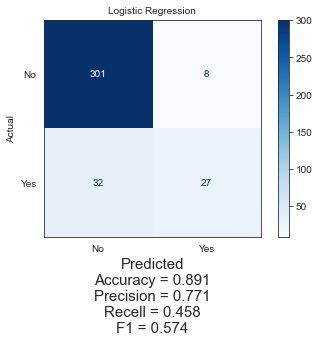

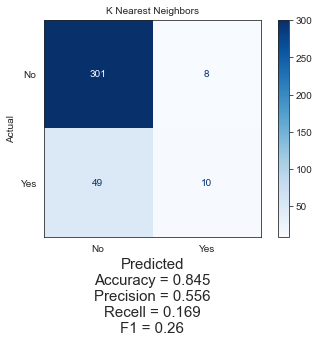

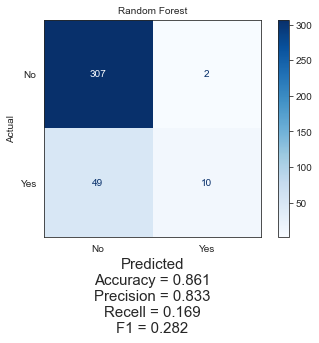

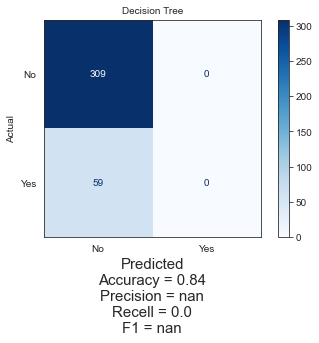

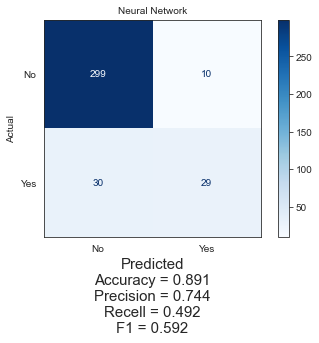

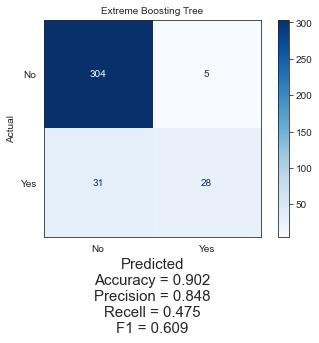

In [56]:
plot_cm(best_models)

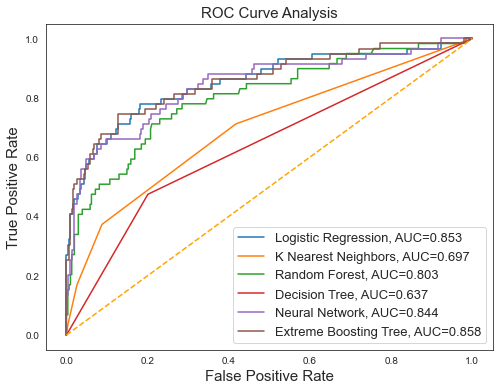

In [57]:
# visualize ROC curve for each optimized model
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
for model_name, model in best_models:
        yproba = model.predict_proba(X_test)[::,1]

        fpr, tpr, _ = roc_curve(y_test,  yproba)
        auc = roc_auc_score(y_test, yproba)
        result_table = result_table.append({'classifiers':model_name,
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis',fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.savefig('outputs/ROC_curve_analysis.png')

# 6. Data Augmentation

In [58]:
y_aug = copy.deepcopy(y.values)
x_aug = copy.deepcopy(df_clean.values)

X_train, X_test, y_train, y_test = train_test_split(x_aug, y_aug, 
                                                    stratify=y)


Counter({0: 924, 1: 178})



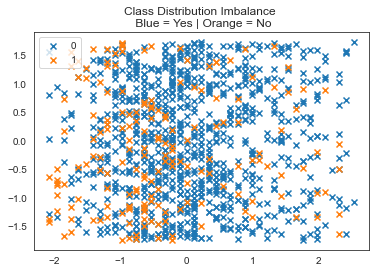

In [59]:

# Class distribution summary
counter = Counter(y_train)
print(counter)
print()

# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y_train == label)[0]
	plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label), marker= 'x' )
plt.legend()
plt.title('Class Distribution Imbalance \n Blue = Yes | Orange = No')
plt.savefig('outputs/imbalanced_data.png')
plt.show()


Counter({0: 924, 1: 924})


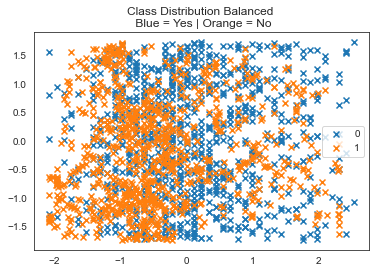

In [60]:
# transform the dataset
smt = SMOTE(random_state=0)
X_train_aug, y_train_aug = smt.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_train_aug)
print(counter)

# See how the SMOTE classifier has transformed the training set
for label, _ in counter.items():
	row_ix = where(y_train_aug == label)[0]
	plt.scatter(X_train_aug[row_ix, 0], X_train_aug[row_ix, 1], label=str(label), marker= 'x')
plt.legend()
plt.title('Class Distribution Balanced \n Blue = Yes | Orange = No')
plt.savefig('outputs/balanced_data.png')
plt.show()


# 7. Feature importance

In [61]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
importance = lr.coef_[0]


In [62]:
merged_list = [(list(df.columns)[i],importance[i]) for i in range(0, len((list(df.columns))))]
sorted_imp = sorted(merged_list, key=lambda x: x[-1], reverse=True)
sorted_imp[:10]


[('JobLevel', 1.722347142934091),
 ('TotalWorkingYears', 1.5332846412113),
 ('YearsInCurrentRole', 1.0564001110818364),
 ('PercentSalaryHike', 0.8438693095405622),
 ('TrainingTimesLastYear', 0.6715075217717481),
 ('JobInvolvement', 0.47177719934995443),
 ('RelationshipSatisfaction', 0.3934903194343203),
 ('WorkLifeBalance', 0.3311115162640312),
 ('BusinessTravel', 0.3250422662733552),
 ('YearsAtCompany', 0.1505343462669365)]

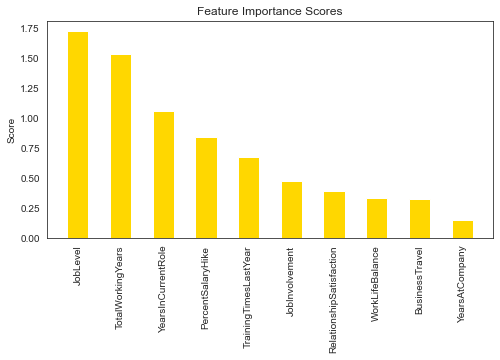

In [63]:


labels = [i[0] for i in sorted_imp[:10]]
scores_lst = [i[1] for i in sorted_imp[:10]]
x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x, scores_lst, 0.5, color='gold')
ax.set_ylabel('Score')
ax.set_title('Feature Importance Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.savefig('outputs/feature_importance.png')
plt.show()
